In [1]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from tqdm.auto import tqdm
from numpy.random import default_rng
import matplotlib.pyplot as plt
from movement import *
from firedrake.meshadapt import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ring_monitor(mesh):
    alpha = Constant(20.0)  # amplitude
    beta = Constant(200.0)  # width
    gamma = Constant(0.15)  # radius
    x, y = SpatialCoordinate(mesh)
    r = (x - 0.5)**2 + (y - 0.5)**2
    return Constant(1.0) + alpha/cosh(beta*(r - gamma))**2

In [7]:
def pde_monitor(mesh,u):
    """
    Create a monitor function for mesh adaptation, based on the trace of the Hessian of the PDE solution.
    """
    # Define the Riemannian metric
    P1_tensor = TensorFunctionSpace(mesh, "CG", 1)
    metric = RiemannianMetric(P1_tensor)

    # Compute the Hessian of the current solution
    hessian = metric.compute_hessian(u)

    P1 = FunctionSpace(mesh, "CG", 1)
    
    beta = Constant(0.1)
    Hnorm = Function(P1).interpolate(sqrt(inner(hessian, hessian)))
    Hnorm_max = Hnorm.dat.data[:].max()                                 
    monitor = Function(P1).interpolate(1 + beta * Hnorm/Hnorm_max)
   
    return monitor


In [7]:
# Generate random fields
def random_field(V, N: int = 1, m: int = 5, σ: float = 0.6, seed: int = 2023):
    rng = default_rng(seed)
    x, y = SpatialCoordinate(V.mesh())
    fields = []
    for _ in tqdm(range(N), disable=False):
        r = 0
        for _ in range(m):
            a, b = rng.standard_normal(2)
            k1, k2 = rng.normal(0, σ, 2)
            θ = 2 * np.pi * (k1 * x + k2 * y)
            r += Constant(a/2) * cos(θ) + Constant(b/2) * sin(θ) + Constant(1)
        fields.append(Function(V).interpolate(sqrt(1 / m) * r))
    return fields

In [17]:
# Define the function space
nx, ny, Lx, Ly = 10, 10, 1., 1.
mesh = RectangleMesh(nx, ny, Lx, Ly)
V = FunctionSpace(mesh, "CG", 1)

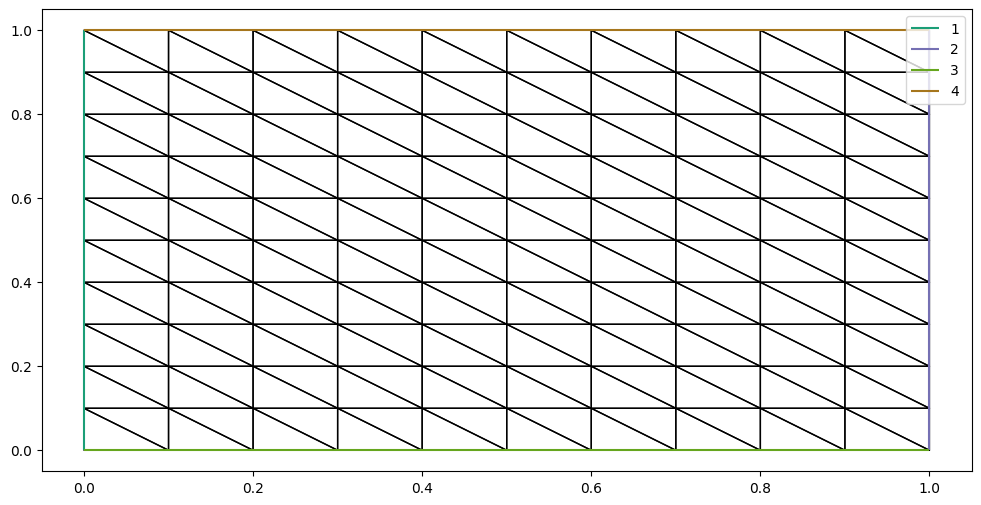

In [18]:
#visualize initial mesh
fig, axes = plt.subplots(figsize=(12, 6))
triplot(mesh, axes=axes)
axes.legend()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 116.24it/s]


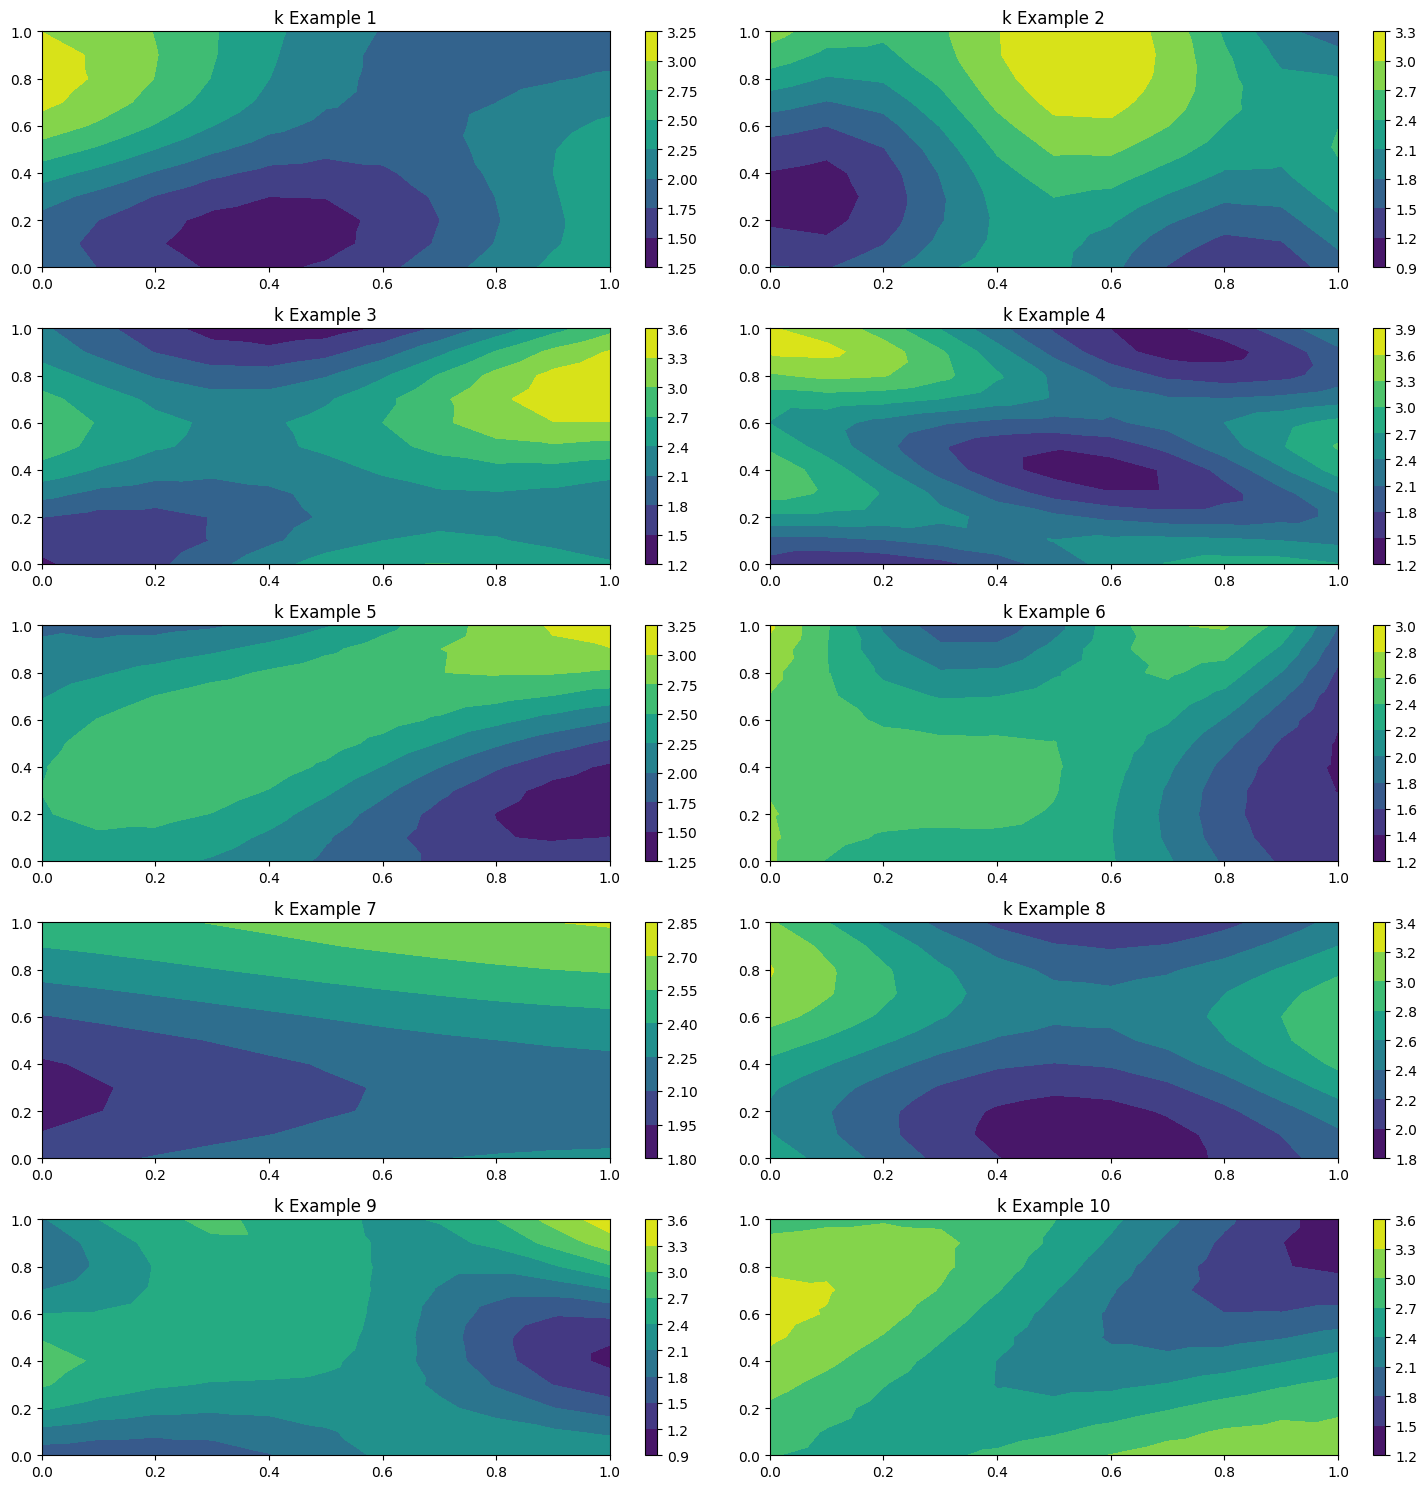

In [19]:
# Generate random field data for 10 examples
ks = random_field(V, N=10) 

# Visualize the 10 training data in 5x2 subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

# Plot each random field in a separate subplot
for i in range(5):
    for j in range(2):
        index = 2*i + j
        k_plot = tricontourf(ks[index], axes=axs[i, j])
        plt.colorbar(k_plot, ax=axs[i, j])
        axs[i, j].set_title(f'k Example {index + 1}')
plt.tight_layout()
plt.show()

In [20]:
ks = random_field(V, N=1)
us = []
v = TestFunction(V)
x, y = SpatialCoordinate(mesh)
f = Function(V).interpolate(sin(np.pi * x) * sin(np.pi * y))
bcs = [DirichletBC(V, Constant(0.0), "on_boundary")]
for k in tqdm(ks):
    u = Function(V)
    F = (inner(exp(k) * grad(u), grad(v)) - inner(f, v)) * dx
    solve(F == 0, u, bcs=bcs, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    us.append(u)

100%|██████████| 1/1 [00:00<00:00, 55.64it/s]


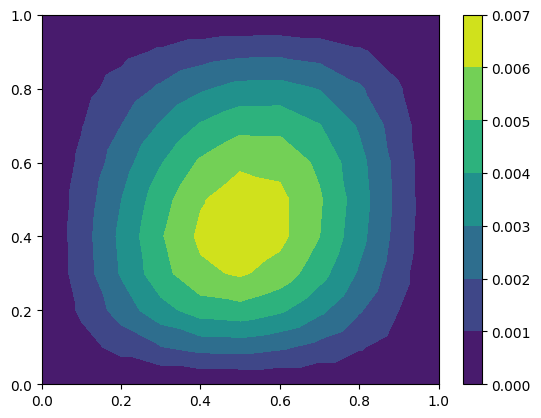

In [21]:
# Plot u
u_plot = tricontourf(us[0])
plt.colorbar(u_plot)
plt.show()

In [27]:
for u in tqdm(us):
    
    def pde_monitor(mesh):

        # Define the Riemannian metric
        P1_tensor = TensorFunctionSpace(mesh, "CG", 1)
        metric = RiemannianMetric(P1_tensor)

        # Compute the Hessian of the current solution
        hessian = metric.compute_hessian(u)

        P1 = FunctionSpace(mesh, "CG", 1)
        
        beta = Constant(2)
        Hnorm = Function(P1).interpolate(sqrt(inner(hessian, hessian)))
        Hnorm_max = Hnorm.dat.data[:].max()                                 
        monitor = Function(P1).interpolate(1 + beta * Hnorm/Hnorm_max)
        
        return monitor
    mover = MongeAmpereMover(mesh, pde_monitor, method="quasi_newton")
    mover.move()

  0%|          | 0/1 [00:00<?, ?it/s]

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


   0   Min/Max 4.0413e-01   Residual 1.9813e-01   Equidistribution 9.8616e-01
   1   Min/Max 6.8146e-01   Residual 4.8428e-02   Equidistribution 9.9143e-01
   2   Min/Max 7.7094e-01   Residual 1.5341e-02   Equidistribution 9.9236e-01
   3   Min/Max 7.7310e-01   Residual 6.5587e-03   Equidistribution 9.9237e-01
   4   Min/Max 7.7717e-01   Residual 2.9445e-03   Equidistribution 9.9237e-01
   5   Min/Max 7.7995e-01   Residual 1.2978e-03   Equidistribution 9.9238e-01
   6   Min/Max 7.8146e-01   Residual 5.6141e-04   Equidistribution 9.9238e-01
   7   Min/Max 7.8219e-01   Residual 2.5049e-04   Equidistribution 9.9238e-01
   8   Min/Max 7.8253e-01   Residual 1.2135e-04   Equidistribution 9.9238e-01
   9   Min/Max 7.8270e-01   Residual 6.2587e-05   Equidistribution 9.9238e-01
  10   Min/Max 7.8277e-01   Residual 3.2433e-05   Equidistribution 9.9238e-01
  11   Min/Max 7.8281e-01   Residual 1.6385e-05   Equidistribution 9.9238e-01
  12   Min/Max 7.8282e-01   Residual 8.0763e-06   Equidistributi

100%|██████████| 1/1 [01:59<00:00, 119.06s/it]

  19   Min/Max 7.8284e-01   Residual 5.7922e-08   Equidistribution 9.9238e-01
Converged in 19 iterations.


In [29]:
V = FunctionSpace(mesh, "CG", 1)
u = Function(V).assign(u)

In [30]:

# Generate observations
scale_noise: float = 2*1e-4
seed: int = 1234
np.random.seed(seed)
us_obs = []
for u in tqdm(us):
    u_obs = Function(V).assign(u)
    u_obs.dat.data[:] += scale_noise * np.random.randn(V.dim())
    us_obs.append(u_obs)

100%|██████████| 1/1 [00:00<00:00, 524.29it/s]


In [34]:
def generate_data(V, ntrain: int = 50, scale_noise: float = 0.01, seed: int = 1234):
    np.random.seed(seed)
    # Generate random fields
    ks = random_field(V, N=ntrain)
    us = []
    v = TestFunction(V)
    x, y = SpatialCoordinate(V.mesh())
    f = Function(V).interpolate(sin(np.pi * x) * sin(np.pi * y))
    bcs = [DirichletBC(V, Constant(0.0), "on_boundary")]
    for k in tqdm(ks):
        u = Function(V)
        F = (inner(exp(k) * grad(u), grad(v)) - inner(f, v)) * dx
        solve(F == 0, u, bcs=bcs, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
        us.append(u)
    # Adapt the mesh based on the solution
    for u in tqdm(us):
        mover = MongeAmpereMover(V.mesh(), pde_monitor(V.mesh(), u), method="quasi_newton")
        mover.move()
    # Generate observations
    us_obs = []
    for u in tqdm(us):
        u_obs = Function(V).assign(u)
        u_obs.dat.data[:] += scale_noise * np.random.randn(V.dim())
        us_obs.append(u_obs)
    return ks, us, us_obs


In [35]:
# Generate data
ntrain = 1
ks_train, us_train, us_obs_train = generate_data(V, ntrain=ntrain)


  0%|          | 0/1 [00:01<?, ?it/s]


ValueError: setting an array element with a sequence.

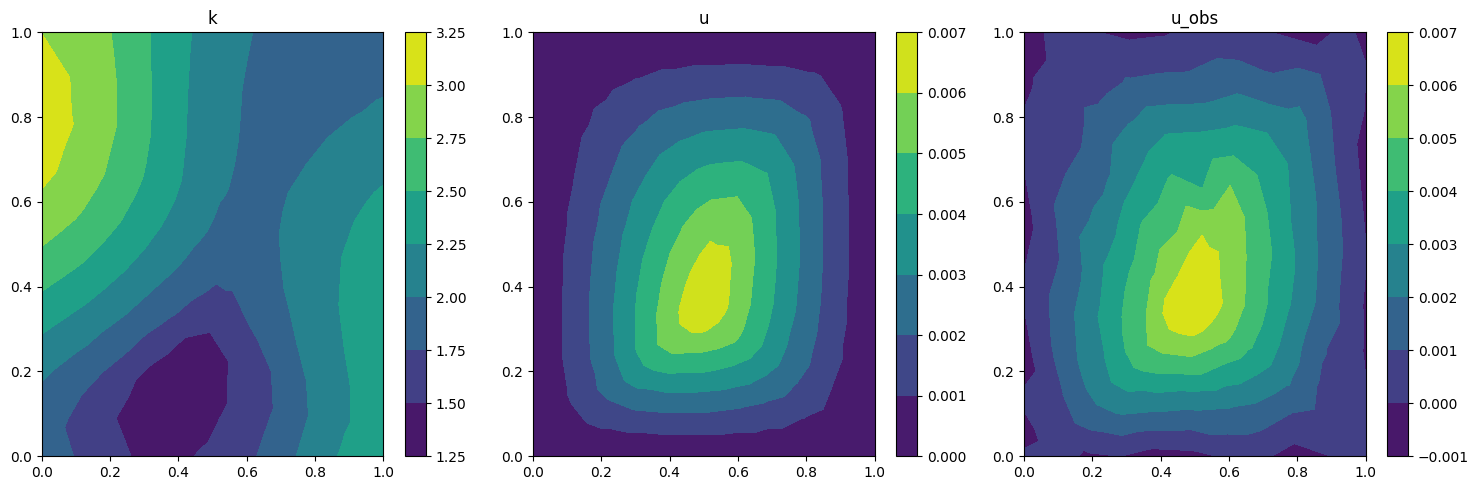

In [31]:
# Visualize one of the training data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot k
k_plot = tricontourf(ks[0], axes=axs[0])
plt.colorbar(k_plot, ax=axs[0])
axs[0].set_title('k')

# Plot u
u_plot = tricontourf(us[0], axes=axs[1])
plt.colorbar(u_plot, ax=axs[1])
axs[1].set_title('u')

# Plot u_obs
u_obs_plot = tricontourf(us_obs[0], axes=axs[2])
plt.colorbar(u_obs_plot, ax=axs[2])
axs[2].set_title('u_obs')

plt.tight_layout()
plt.show()

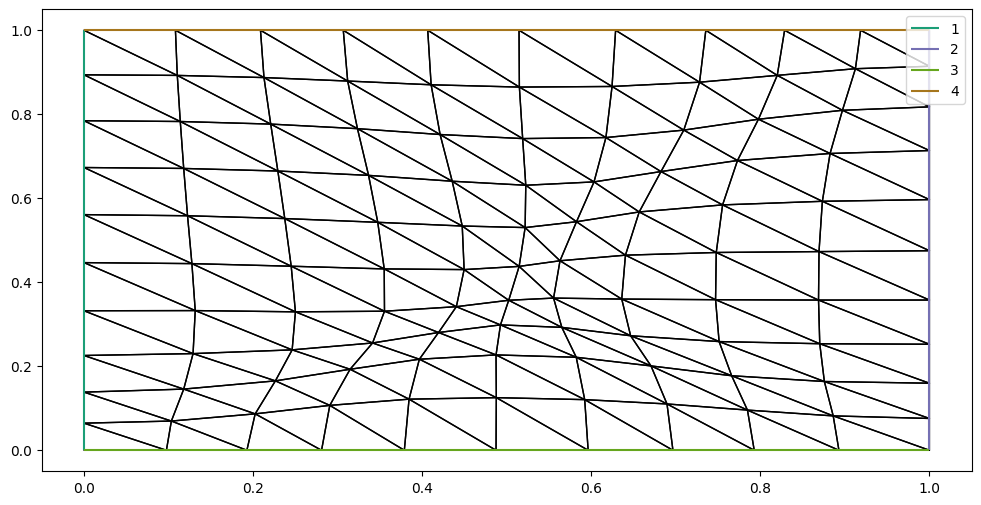

In [32]:
#visualize adapted mesh
fig, axes = plt.subplots(figsize=(12, 6))
triplot(mesh, axes=axes)
axes.legend()
plt.show()

In [29]:
import torch
from torch.utils.data import Dataset
from firedrake.ml.pytorch import *
# Define BatchElement and BatchedElement data classes
from dataclasses import dataclass
from typing import NamedTuple, List, Optional

@dataclass
class BatchElement:
    target: torch.Tensor
    u_obs: torch.Tensor
    target_fd: Function
    u_obs_fd: Function

@dataclass
class BatchedElement:
    target: torch.Tensor
    u_obs: torch.Tensor
    target_fd: List[Function]
    u_obs_fd: List[Function]
    batch_elements: Optional[List[BatchElement]] = None

# Define PDEDataset class
class PDEDataset(Dataset):
    def __init__(self, ks_train, us_obs_train):
        self.data = [(k, u_obs) for k, u_obs in zip(ks_train, us_obs_train)]
    
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> BatchElement:
        target_fd, u_obs_fd = self.data[idx]
        # Convert Firedrake functions to PyTorch tensors
        target, u_obs = [to_torch(e) for e in [target_fd, u_obs_fd]]
        return BatchElement(target=target, u_obs=u_obs, target_fd=target_fd, u_obs_fd=u_obs_fd)
    
    def collate(self, batch_elements: List[BatchElement]) -> BatchedElement:
        batch_size = len(batch_elements)
        n = max(e.u_obs.size(-1) for e in batch_elements)
        m = max(e.target.size(-1) for e in batch_elements)

        u_obs = torch.zeros(batch_size, n, dtype=batch_elements[0].u_obs.dtype)
        target = torch.zeros(batch_size, m, dtype=batch_elements[0].target.dtype)
        target_fd = []
        u_obs_fd = []
        for i, e in enumerate(batch_elements):
            u_obs[i, :] = e.u_obs
            target[i, :] = e.target
            target_fd.append(e.target_fd)
            u_obs_fd.append(e.u_obs_fd)

        return BatchedElement(u_obs=u_obs, target=target,
                              target_fd=target_fd, u_obs_fd=u_obs_fd,
                              batch_elements=batch_elements)

# Instantiate PDEDataset
dataset = PDEDataset(ks_train, us_obs_train)

# Get a single sample from the dataset
sample = dataset[0]
print(f"target: {sample.target}\nu_obs: {sample.u_obs}")

# Get a batch from the dataset
batch_size = 4
batch = dataset.collate([dataset[i] for i in range(batch_size)])
print(f"batch u_obs size: {batch.u_obs.size()}\nbatch target size: {batch.target.size()}")


NameError: name 'ks_train' is not defined